# Series de Tiempo: Análisis exploratorio y modelos Ingenuos
Juan Pavez, Héctor Allende

Una forma de representar las series de tiempo es usando modelos ingenuos. 

Es buena idea observar estos modelos antes de intentar con modelos más avanzados, como los ARIMA.

Estos modelos se basan en descomponer la serie en terminos de:
 * T: tendencia de la serie. Es la dirección predominante de la serie.
 * E: Variación estacional. Caracteriza periodos o ciclos de la serie.
 * A: Variaciones accidentales. Variaciones aleatorias de la serie.

Estos Modelos son:
 * Modelo Aditivo: $x(t) = T(t) + E(t) + A(T)$ 
 * Modelo Multiplicativo: $x(t) = T(t) E(t) A(t)$
 * Modelo Mixto: $x(t) = T(t) E(t) + A (T)$

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import random
import numpy as np
np.random.seed(1337)  # for reproducibility
random.seed(1337)

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('bmh')

import seaborn as sb

Comenzaremos definiendo una serie de indices trimestrales de precios al por mayor (entre 1977 y 1981)

In [4]:
price_index = [120, 90, 90, 100, 130, 110, 110, 130, 140, 120, 110, 150, 150, 140, 140, 170, 180, 180, 170, 190]
date_range = pd.date_range('1977-01-01', periods=20, freq='3M')
series = pd.Series(price_index, date_range)

In [5]:
price_index = np.array(price_index)

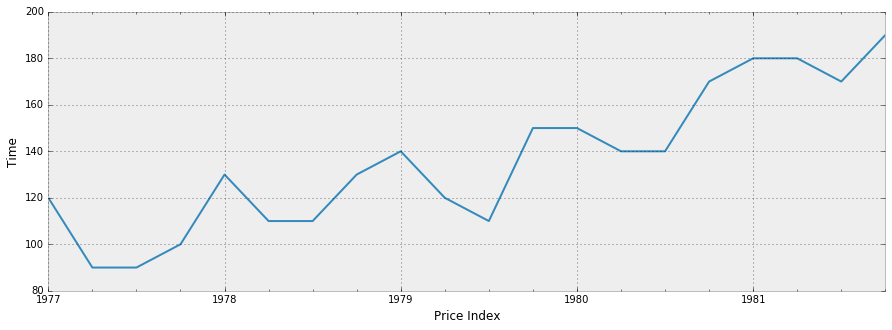

In [6]:
series.plot(figsize=(15,5))
plt.xlabel('Price Index')
plt.ylabel('Time')

# Estimación de tendencia
Para estimar la tendencia se pueden seguir varios caminos.
Uno puede ser la estimación mediante regresión.
## Regresión.
Se ajusta una curva mediante mínimos cuadrados. La curva se puede decidir mediante inspección gráfica u otro método más avanzado.

Una opción es ajustar una regresión lineal simple:
$$ \hat{T}(t) = \beta_0 + \beta_1 t $$

In [7]:
def linear_trend(t, a, b): return a + b*t
# To estimate the values, using least squares
x = np.array(range(1, len(price_index) + 1))
y = np.array(price_index)
n = len(x)
# From the least square solutions, for equispaced
b_hat = (np.sum(np.multiply(x, y)) - (1./2.)*(n + 1.)*np.sum(y)) /  ((1./12.) * (n*(n**2 - 1)))
a_hat = (1./n) * np.sum(y) - (1./2.)*(n+1) * b_hat


In [8]:
print('Slope : {0}, Intercept: {1}'.format(b_hat, a_hat))

Slope : 4.6015037594, Intercept: 87.6842105263


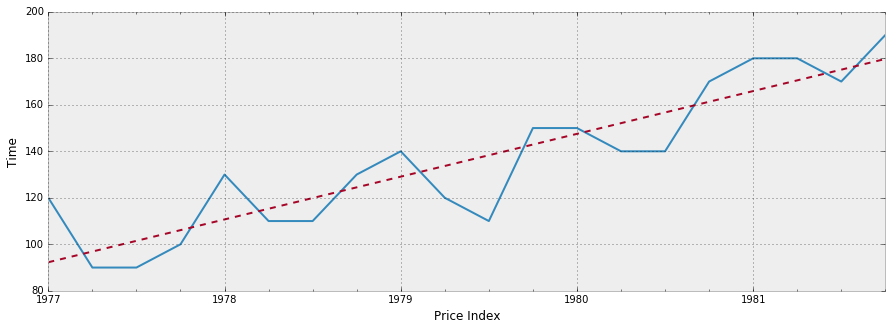

In [9]:
series.plot(figsize=(15,5))
trend = pd.Series(map(lambda x: linear_trend(x, a_hat, b_hat), x), date_range)
trend.plot(style='--')
plt.xlabel('Price Index')
plt.ylabel('Time')

También podemos usar las herramientas de la librería stats.

In [10]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print('Slope : {0}, Intercept: {1}'.format(slope, intercept))

Slope : 4.6015037594, Intercept: 87.6842105263


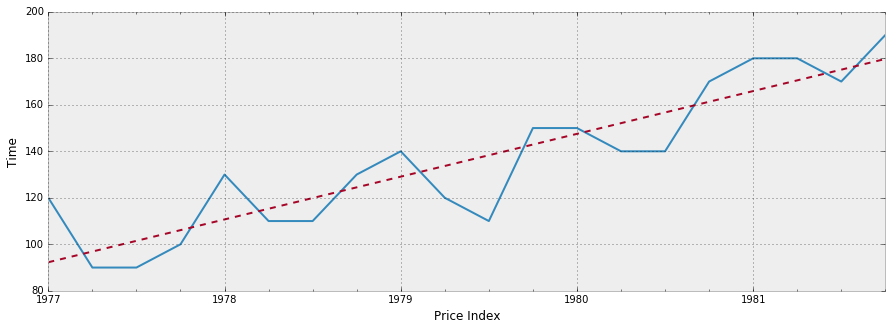

In [11]:
series.plot(figsize=(15,5))
trend = pd.Series(map(lambda x: x*slope + intercept, x), date_range)
trend.plot(style='--')
plt.xlabel('Price Index')
plt.ylabel('Time')

Otra forma de calcular la tendencia es usando el método de Medias Móviles.
## Medias Móviles

La idea es suavizar los valores según sus valores vecinos y considerando los posibles efectos estacionales. 

Si la serie es trimestral y los efectos estacionales son anuales entonces calcularíamos la nueva serie $z(t)$ como:

$$ z(k) = \frac{\frac{1}{2} x(k-2) + k(k-1) + x(k) + x(k+1) + \frac{1}{2} x(k+2)}{4} $$

Luego se puede calcular la tendencia directamente en esta serie suavizada.


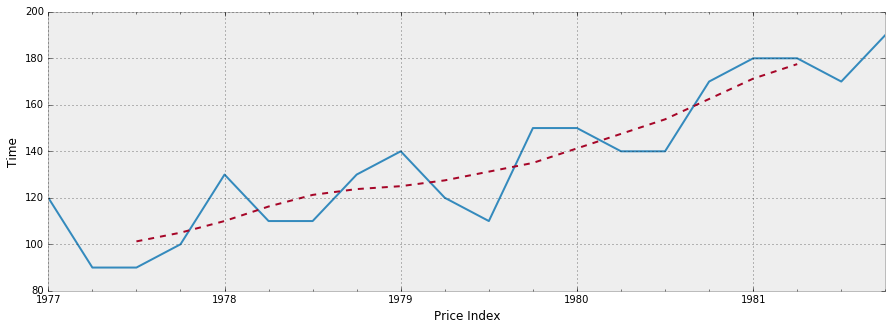

In [12]:
def rolling_average(x, k): return ((1./2.) * x[k-2] + x[k-1] + x[k] + x[k+1] + (1./2.)*x[k+2])/4.

series.plot(figsize=(15,5))
trend = pd.Series(map(lambda x: rolling_average(y,x), x[1:-3]), date_range[2:-2])
trend.plot(style='--')
plt.xlabel('Price Index')
plt.ylabel('Time')

También podemos usar las herramientas de pandas

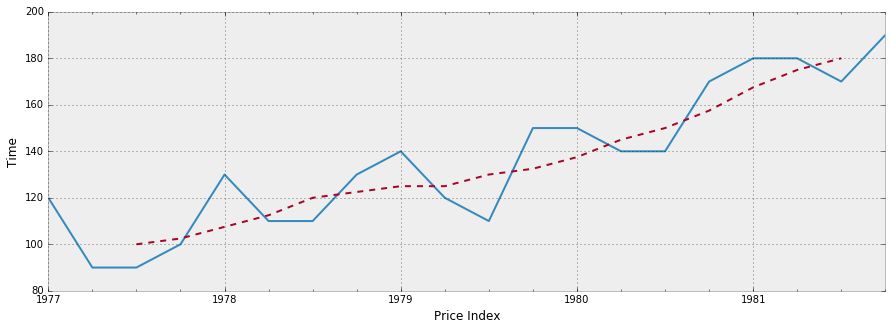

In [13]:
rolling_averages = series.rolling(window=4, center=True).mean()

series.plot(figsize=(15,5))
rolling_averages.plot(style='--')
plt.xlabel('Price Index')
plt.ylabel('Time')

In [14]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[2:-1], rolling_averages.values[2:-1])
print('Slope : {0}, Intercept: {1}'.format(slope, intercept))

def trend(t): return linear_trend(t, intercept, slope)

Slope : 4.78553921569, Intercept: 82.0649509804


# Estimación de Variación Estacional

Ya calculada la tendencia $\hat{T}$ o las medias móviles $z(t)$ se puede extraer la tendencia de la serie:

$x(t) - \hat{T}$ (En el caso aditivo)


$x(t) / \hat{T}$ (En el caso mixto)

o en el caso de usar medias móviles:


$x(t) - z(t)$ (En el caso aditivo)


$x(t) / z(t)$ (En el caso mixto)

El resultado será una serie que sólo contendrá los efecto estacionales y accidentales o aleatorios. Esta serie la denominamos $w(t)$ (serie residual)


Para estimar la variación estacional se usa la serie residual. El método más común es promediando los valores de la serie residual para cada una de las posiciones estacionales. 

Por ejemplo si los datos son trimestales con estacionalidad anual asumimos que:
$$ E(t) = E(t + 4) = E(t + 8) $$
Entonces sólo se debe estimar
$$ E(1), E(2), E(3), E(4)$$

Para esto calculamos el promedio de los valores para todos los años de cada trimestre

$e(h)$ = promedio de valores de $w(h)$ para trimestre h

Finalmente calculamos

$$\overline{e} = \frac{1}{4} \sum_1^4 e(h)$$

Y dado que queremos que nuestras estimaciones sean 0 en el caso aditivo y 1 en el mixto, estimamos $E(h)$ como:

$ \hat{E}(h) = e(h) - \overline{e}$ (caso aditivo)

$ \hat{E}(h) = e(h) - (\overline{e} - 1)$ (caso mixto)


In [15]:
observed = y[2:-1]
averages = rolling_averages.values[2:-1]
residual = observed / averages

In [16]:
residuals = pd.Series(residual, date_range[2:-1])
print(residuals)

1977-07-31    0.900000
1977-10-31    0.975610
1978-01-31    1.209302
1978-04-30    0.977778
1978-07-31    0.916667
1978-10-31    1.061224
1979-01-31    1.120000
1979-04-30    0.960000
1979-07-31    0.846154
1979-10-31    1.132075
1980-01-31    1.090909
1980-04-30    0.965517
1980-07-31    0.933333
1980-10-31    1.079365
1981-01-31    1.074627
1981-04-30    1.028571
1981-07-31    0.944444
Freq: 3M, dtype: float64


In [17]:
residual = np.hstack((np.zeros(2), residual, np.zeros(1)))
e = np.array(np.split(residual, 5))
e = np.average(e, axis=0, weights=e.astype(bool))
E = e - (np.mean(e) - 1.)

Ya teniendo la variación estacional y tendencia podemos hacer predicciones de la siguiente manera

$ \hat{X}(k) = \hat{T}(k) + \hat{E}(k \% 4) $ (modelo aditivo)

$ \hat{X}(k) = \hat{T}(k)\hat{E}(k \% 4) $ (modelo multiplicativo)

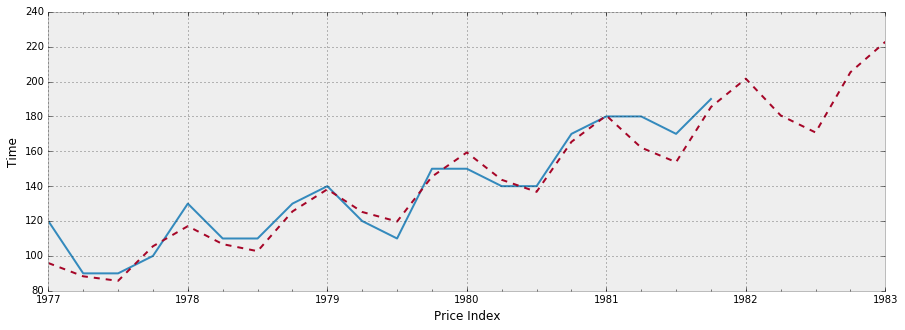

In [18]:
plot_range = 25
x_hat = map(lambda x: trend(x) * E[(x-1) % 4], range(1, plot_range + 1))
date_range_new =  pd.date_range('1977-01-01', periods=plot_range, freq='3M')
x_hat_serie = pd.Series(x_hat, date_range_new)
series.plot(figsize=(15,5))
x_hat_serie.plot(style='--')
plt.xlabel('Price Index')
plt.ylabel('Time')

Todo esto puede ser por supuesto simplificado usando herramientas de python

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

/home/jpavez/miniconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


[]

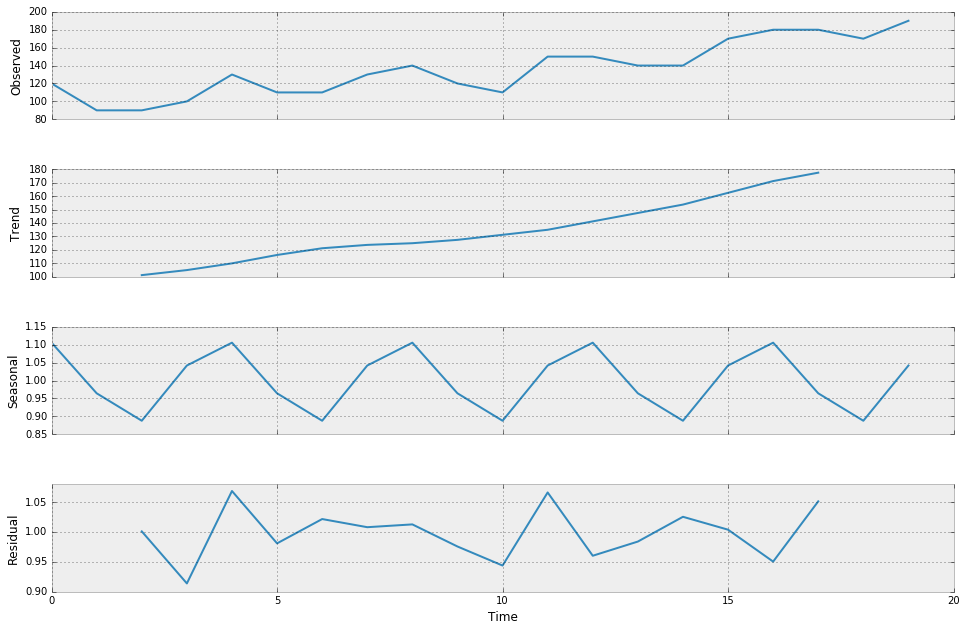

In [20]:
result = seasonal_decompose(series.values, model='mutliplicative', freq=4)
fig = result.plot()
fig.set_size_inches(15,10)
plt.plot()

# Serie de tiempo de temperaturas globales

Ahora trabajaremos con una serie correspondiente a los datos del índice de temperatura global promedio en el periodo de 1880-2017. En específico los datos corresponden a desviaciones medidas en grados centigrados.

Estos datos parecen mostrar una tendencia al alza, este hecho ha sido utilizado como argumento para el calentamiento global. 

In [22]:
data_url = 'https://data.giss.nasa.gov/gistemp/tabledata_v3/GLB.Ts+dSST.csv'
df = pd.read_csv(data_url, header=1)

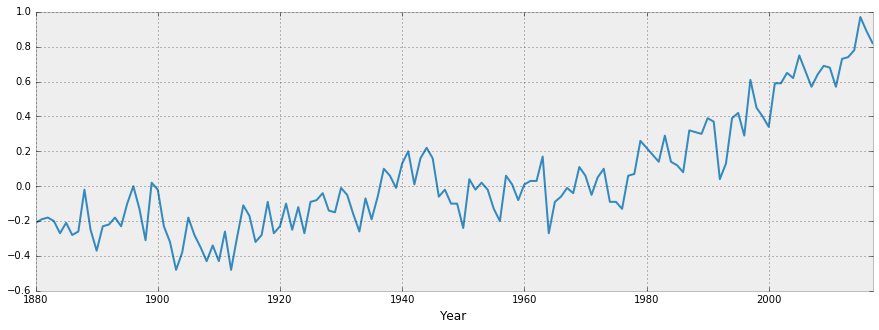

In [23]:
gt_serie = pd.Series([float(d) for d in df.SON[:-1].values], index=df.Year[:-1])
gt_serie.plot(figsize=(15,5))

Como un primer paso exploratorio comenzaremos por observar la decomposición de la serie en un modelo ingenuo aditivo.

[]

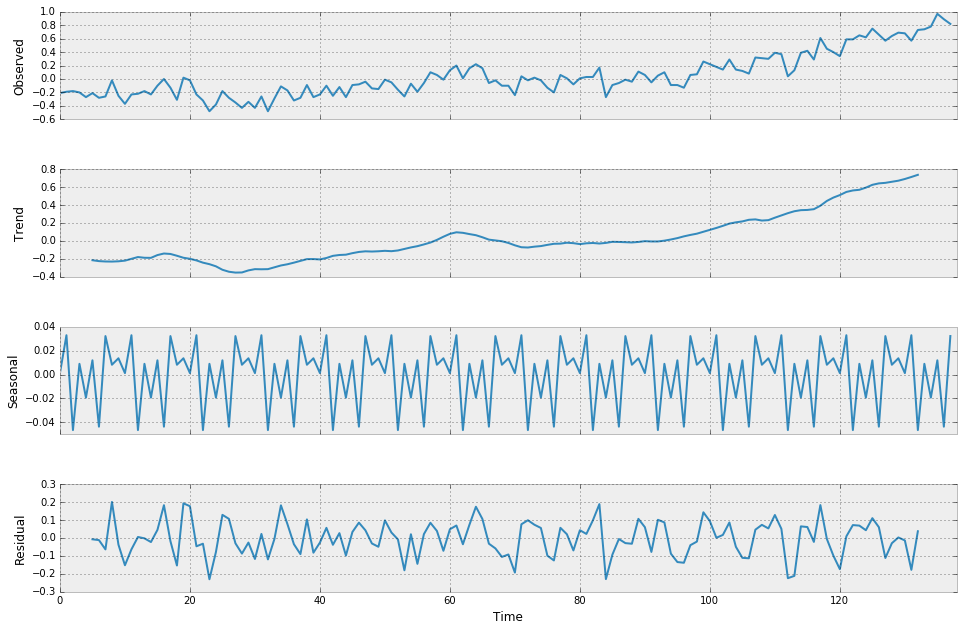

In [24]:
result = seasonal_decompose(gt_serie.values, model='additive', freq=10)
fig = result.plot()
fig.set_size_inches(15,10)
plt.plot()

## Evaluando el autocorrelograma

Como habíamos visto en la sesión teórica, una propiedad fundamental para realizar análisis en series de tiempo es la estacionalidad. En series de tiempo la dependencia entre diferentes lags es lo importante a evaluar. Si la serie esta cambiando en el tiempo entonces la dependencia sería dificil de evaluar. La segunda condición de estacionaridad justamente evita esto. 

Una herramienta fundamental para evaluar la propiedad de estacionaridad es el autocorrelograma. El autocorrelograma muestra las autocorrelaciones entre varios lags en una serie de tiempo. Si la serie es estacionaria debemos observar que las autocorrelaciones se vuelven cero luego de algunos lags (bajo cierto intervalo de confianza).

[]

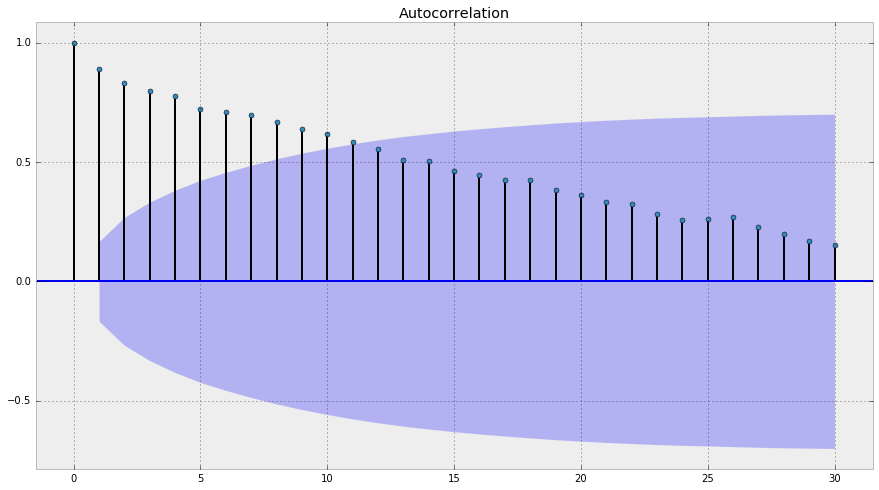

In [25]:
import statsmodels.tsa.api as smt
fig = smt.graphics.plot_acf(gt_serie, lags=30, alpha=0.05)
fig.set_size_inches(15,8)
plt.plot()

Una tendencia, por ejemplo, hace a la red no estacionaria, ya que hay una dependencia de la media con el tiempo. Sin embargo, como ya lo vimos, podemos extraer la tendencia de la serie con la finalidad de lograr estacionaridad.

En este caso consideramos un proceso de la forma
$$ x_t = u_t + y_t$$
Donde $u_t$ es la tendencia y $y_t$ es un proceso estacionario.

Entonces si estimamos $u_t$ con $\hat{u}_t$ podemos obtener un proceso estacionario como:
$\hat{y}_t = x_t - \hat{u}_t$

Slope : 0.0067719052305, Intercept: -0.417643624231


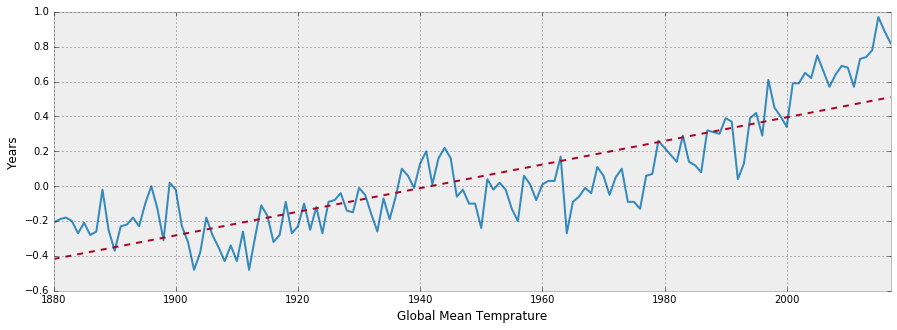

In [26]:
y = gt_serie.values
x = range(len(y))
date_range = pd.date_range('1880', '2018', freq='Y')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print('Slope : {0}, Intercept: {1}'.format(slope, intercept))
gt_serie.plot(figsize=(15,5))
trend = pd.Series(map(lambda x: x*slope + intercept, x), df.Year.values[:-1])
trend.plot(style='--')
plt.xlabel('Global Mean Temprature')
plt.ylabel('Years')

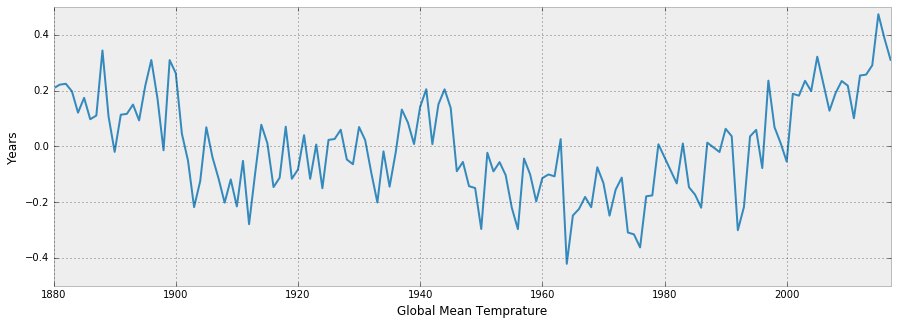

In [27]:
trend = map(lambda x: x*slope + intercept, x)
detrend = y - trend
detrend = pd.Series(detrend, df.Year.values[:-1])
detrend.plot(figsize=(15,5))
plt.xlabel('Global Mean Temprature')
plt.ylabel('Years')

[]

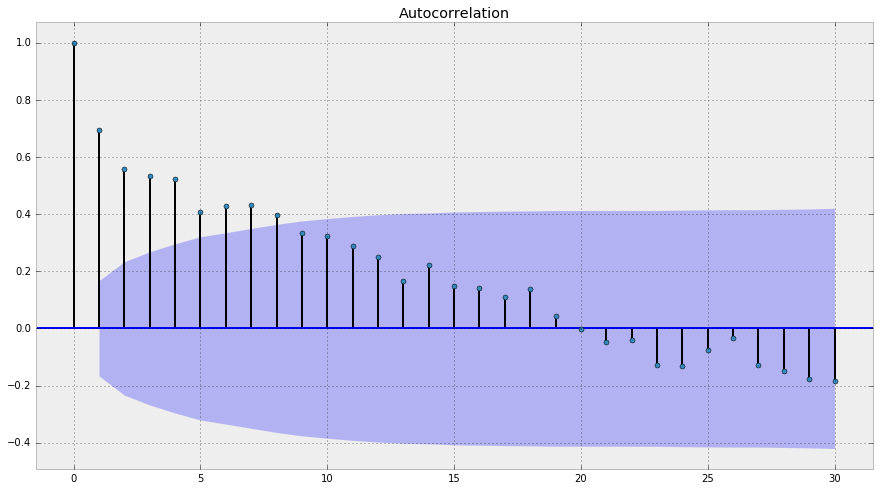

In [28]:
fig = smt.graphics.plot_acf(detrend, lags=30, alpha=0.05)
fig.set_size_inches(15,8)
plt.plot()

Otra forma para eliminar la tendencia de una serie es mediante la diferenciación. Para observar esto:

Si $u_t = a + bt$
\begin{align} 
x_t - x_{t-1} &=& (u_t - y_t) - (u_{t-1} - y_{t-1})\\
  &=& b\Delta +  y_t - y_{t-1}
\end{align}
Que se puede demostrar es estacionario.

Incluso si observamos una tendencia más compleja, como por ejemplo un random walk with drift:
$$ u_t = \delta + u_{t-1} + w_t $$
Entonces
$$ x_t - x_{t-1} = \delta + w_t + y_t - y_{t-1} $$
Que tambien es estacionario.

Para comparar ambos métodos podemos observar:
 * La diferenciación no involucra estimación de parámetros. Sin embargo no entrega directamente un estimador de $y_t$.
 * El detrending involucra estimación de parámetros, pero permite estimar directamente $y_t$.

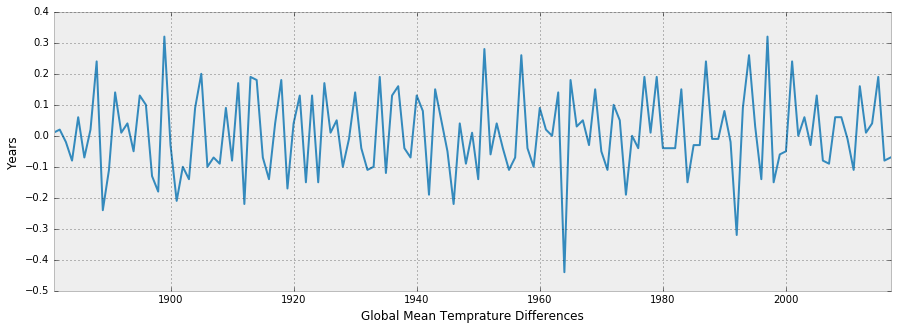

In [78]:
diff_serie = pd.Series(np.diff(gt_serie), df.Year[1:-1])
diff_serie.plot(figsize=(15,5))
plt.xlabel('Global Mean Temprature Differences')
plt.ylabel('Years')

[]

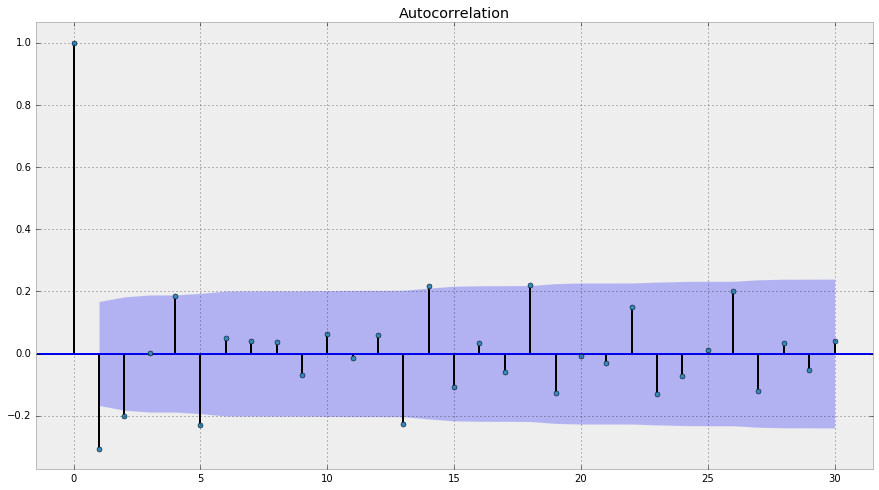

In [79]:
fig = smt.graphics.plot_acf(diff_serie, lags=30, alpha=0.05)
fig.set_size_inches(15,8)
plt.plot()

Para este caso la diferenciación funciona mucho mejor. Esto podría indicar que la tendencia en este proceso es un camino aleatoreo. 

Es interesante observar que en este caso el valor estimado del drift es $\delta = 0.006$, pero con una deviación estándar de $sd(\delta) = 0.009$.

# Gráfico de dispersión de autocorrelaciones

Hasta ahora hemos trabajado con las aucorrelaciones. Sin embargo, como habíamos mencionado en la sesión teórica la autocorrelación sólo mide la relación lineal entre dos variables. Esto significa que si hay relaciones no lineales podríamos estar haciendo conclusiones erróneas. Para evaluar esto podemos utilizar la matriz de dispersión de las autocorrelaciones.


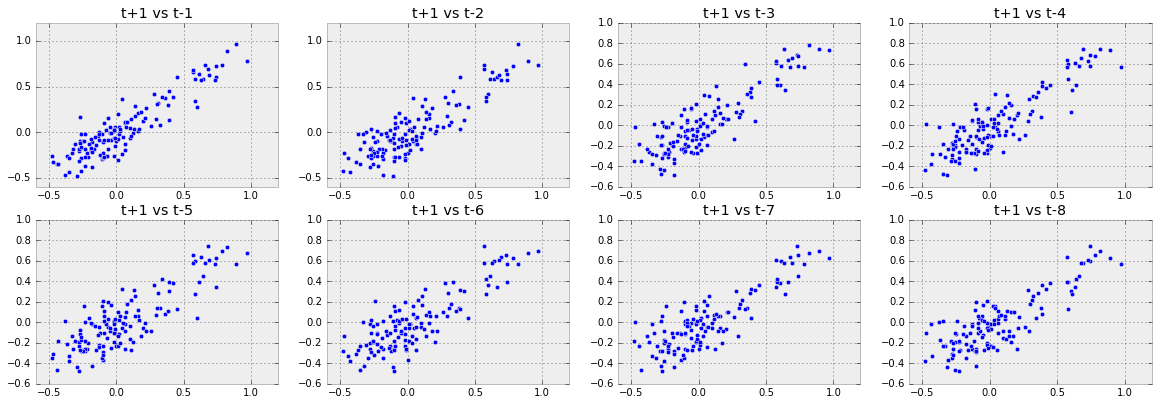

In [93]:
from pandas import concat
from pandas.plotting import scatter_matrix
values = pd.DataFrame(gt_serie.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1, figsize=(20,10))
for i in range(1,(lags + 1)):
    ax = plt.subplot(340 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
plt.show()